# Introduction
In this notebook, we will create an Elo rating system for tennis players and do some analysis on the choice of parameters. We find that a random choice of parameters actually does quite well, and that a wide variety of K-factor weight functions do a good job predicting the outcomes of tennis matches. In future notebooks, we will further expand upon this model by adding various features. 

# Background
The Elo rating system is designed to assign ratings to players which reflect their true strength at the game. Players are assigned an initial rating of 1. Before a match between two players, the system outputs a probability that one wins. After the match, the system updates each player's rating according to their previous ratings and the result of the match.  

Define $$\sigma(x) = \exp(x) / (\exp(x) + 1),$$ the logistic function, and let $K$ be a constant. If player one (p1) has rating $x$ and player two (p2) has rating $y$, the probability that p1 wins is given by $\sigma(x-y)$. Suppose $w=1$ if p1 wins and $w=0$ if p1 loses. After the match, the ratings are updated with the rule $$x \mapsto x + (-1)^{w+1} \sigma((-1)^w(x-y)),\quad y \mapsto y+(-1)^w \sigma((-1)^w (x-y)).$$  

Let's see why this makes any sense. Suppose we are starting from scratch and we want to develop this kind of rating system, but have no idea what the win probability and the update rule should be. Heuristically, it makes sense to suppose that $W,U$ are functions of the difference $x-y$ rather than the separate ratings $x,y$. Let $W(x-y)$ be the probability that p1 wins against p2, and let $U(x-y)$ be the update rule if p1 loses and $U(y-x)$ be the update rule if p1 wins, so that $$ x\mapsto x+(-1)^{w+1} U((-1)^w(x-y)),\quad y\mapsto y+(-1)^w U((-1)^w(x-y)). $$ We need $W$ and $U$ to satisfy some basic rules.  

First, $W(x-y) = 1-W(y-x)$ so $$W(z)+W(-z)=1.$$ 

Second, $$\lim_{x\to \infty} W(x)=1 ~\text{ and }~ \lim_{x\to-\infty} U(x) = 0.$$

Third and last, *the expected update of both players must be zero*. This is because the strengths of the players shouldn't actually change after a match, so the Elo rating (which is supposed to reflect true strength) shouldn't do that. Here, $w$ is the random quantity in question (make sure to distinguish between little $w$ and capital $W$: the relationship is that $W(x-y)$ should estimate $P(w=1)$). Since the expected update of both players equals zero, we have $$ W(x-y) \cdot U(y-x) - W(y-x) \cdot U(x-y) = 0. $$ In other words, $$ \frac{W(z)}{W(-z)} = \frac{U(z)}{U(-z)}.$$  
In fact, these are the only real mathematical requirements for such a rating system. (See [Aldous](https://www.stat.berkeley.edu/~aldous/Papers/me-Elo-SS.pdf) for more details and assumptions.) As we see, an easy choice would be to set $KW=U$, where $K$ is any constant greater than zero. And really we may set $W$ to be any cdf, but logistic is the standard choice.  

In practice, the choice of $K$ is quite important, and the constant is called the *K-factor*, not to be confused with the tennis racquet line. This $K$ is the main subject of this note, and we will refer to it many times.  

Generally $K$ is taken to be a decreasing function of the number of matches that the updating player has played. In our case, following FiveThirtyEight's family of functions for $K$, we take $$K(n) = \frac{a}{(b+n)^c},$$ where $n$ is the number of matches played by that player before the match. We will call $K(n)$ the **K-factor function**. All of the analysis of parameters we do below focus on the parameters $a,b,c$ above. 

We will use [Jeff Sackmann](http://jeffsackmann.com)'s immense trove of tennis data; see his [GitHub page](https://github.com/JeffSackmann).

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

def sigmoid(z):
    '''The sigmoid function.'''
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))

class Elo(object):
    
    def __init__(self, 
                 start_year, 
                 end_year, 
                 param = [np.random.random()*2, 
                          np.random.random() * 3 + 2,
                          np.random.random()]):
        
        self.start_year = start_year
        self.end_year = end_year
        self.param = param
            
        self.data = []
        for i in range(start_year, end_year + 1):
            self.data.append(pd.read_csv('./atp/atp_matches_' + str(i) + '.csv'))
        
        # collect all the player names
        self.players = {player for player in self.data[0]['winner_name']}
        self.players = self.players.union({player for player in self.data[0]['loser_name']})
        for i in range(1, end_year - start_year + 1):
            self.players = self.players.union({player for player in self.data[i]['winner_name']})
            self.players = self.players.union({player for player in self.data[i]['loser_name']})            
            
        # ratings are of the form (n, r)
        # where n is the number of matches the player has played
        # and r is their rating.
        self.ratings = {player: (0, 1.0) for player in self.players}
    
    def randomize_param(self):
        '''select random parameters.'''
        self.param[0] = np.random.random() * 2
        self.param[1] = np.random.random() * 3 + 2
        self.param[2] = np.random.random()
    
    def get_param(self):
        return self.param.copy()
    
    def set_param(self, p):
        self.param = p
    
    def k(self, n):
        '''returns the K-factor, which dictates how sensitive ratings are
        to an individual match and depends on the number of matches played.'''
        return self.param[0] * (self.param[1] + n)**(-self.param[2])
    
    
    def update_one(self, x, y, n1, n2):
        '''this function updates one match. 'x','y' are the ratings of
        the winner and loser respectively, 'n1','n2' are the number of matches
        that the winner and loser have played respectively. Returns the
        prior probability that the winner wins, and the values to update 
        the ratings by. '''
        z = sigmoid(y-x)
        u1 = self.k(n1) * z
        u2 = -self.k(n2) * z
        prob = 1-z

        return(prob, u1, u2)
        
    def update_ratings(self, year):
        '''this function updates the ratings of all players in the time frame
        between start_year and end_year. We begin computing log-loss at the
        beginning of year.
        'method' can be ll = log loss error, or wp = win prediction. '''
        # first reset the ratings.
        self.ratings = {player: (0, 1.0) for player in self.players}
        
        cost = 0
        win_pred = 0
        brier_score = 0
        
        for i in range(len(self.data)):
            for j, row in self.data[i].iterrows():
                
                winner = row['winner_name']
                loser = row['loser_name']
                
                # get ratings.
                wnm, wrating = self.ratings[winner]
                lnm, lrating = self.ratings[loser]
                
                # update.
                prob, u1, u2 = self.update_one(wrating, lrating, wnm, lnm)
                self.ratings[winner] = wnm + 1, wrating + u1
                self.ratings[loser] = lnm + 1, lrating + u2
                
                # compute log-loss error or win prediction percentage.
                if(i + self.start_year >= year):
                    cost -= np.log(prob)
                    win_pred += (prob > 0.5)
                    brier_score += (1-prob)**2
        
        # figure out what to divide cost by.
        num_rows = 0
        for i in range(min(len(self.data), self.end_year + 1 - year)):
            num_rows += len(self.data[year - self.start_year - 1 + i])

        return (cost / num_rows, win_pred / num_rows, brier_score / num_rows)
    

# Differences with standard Elo ratings
You may notice that I chose to work with the natural base rather than base-10 with some weird 400 multiplicative factor like with standard Elo ratings. The only difference between these ratings on this notebook and the ratings you may see on FiveThirtyEight or Jeff Sackmann's website is a multiplicative factor of $400/\ln 10\approx 173.72$. There is also an additive factor, but we can ignore that because Elo ratings give the same predictions when the same value is added to all ratings (and all initial ratings). We explain the origin of the multiplicative factor below.

For the standard Elo rating, the win probability of player with rating $x$ (who is facing a player with rating $y$) is $$ \frac{1}{1+10^{(y-x)/400}} = \frac{1}{1+ \exp\left(\frac{\ln 10}{400}(y-x)\right)} $$
So we have to multiply our ratings by $400/\ln 10\approx 173.72$ to get the standard Elo ratings. There's also an additive factor of $1000-173.72$ because generally the tennis ratings start at 1000, and we start at 1.

# Cost functions
There are many ways to measure the accuracy of a prediction model which outputs probabilities. Let $n$ be the number of matches being analyzed and $p_i$ the win probability that the model assigns to the winner for $i=1,2,\ldots,n$.

The easiest to understand is *win prediction rate*, which is simply the proportion of matches for which the model assigns a probability greater than 0.5 to the winner. In the code, win prediction rate is denoted by `wp`. Below, $\mathbb{1}(A)=1$ if $A$ happens and $\mathbb{1}(A)=0$ if $A$ does not happen. Technically this is not a cost function, it's a profit function. Take the negative of this if you want a cost function.
$$\text{wp} = n^{-1}\sum_{i=1}^n \mathbb{1}\{p_i > 0.5\}.$$

Next, we introduce *log-loss error*, appearing in maximum likelihood estimation and logistic regression. In the code, log-loss error is denoted by `ll`.
$$\text{ll} = -n^{-1}\sum_{i=1}^n \log p_i.$$

Finally, we introduce the *Brier score*, which is simply the mean squared error between $p_i, i=1,2,\ldots,n$ and the perfect data which assigns probability one to the winner every time. In the code, Brier score is denoted by `bs`.
$$\text{bs} = n^{-1} \sum_{i=1}^n (1-p_i)^2.$$

Here are some apparent differences between these cost/profit functions.
1. win prediction rate is not continuous (a slight change in probabilities can change 0s to 1s and 1s to 0s) and also flat in many places (with respect to the parameters), so it is less useful for optimization than the other two functions, though still a nice metric.
2. log-loss is not bounded, while Brier score is. To see the difference, suppose $p_1=10^{-100}$. Then this contributes 230 to the log-loss error, while it contributes 1 to the Brier score. So log-loss is less tolerant of wrongly confident predictions.

Let's first look at FiveThirtyEight's model, described in a very nice article about [Serena Williams' dominance over the years](https://fivethirtyeight.com/features/serena-williams-and-the-difference-between-all-time-great-and-greatest-of-all-time/).

# FiveThirtyEight's model
FiveThirtyEight's parameter choices were $$[250/174, 5, 0.4] \approx [1.44, 5, 0.4].$$ Let's test their model with a small and large amount of history. 

In [9]:
elo_538 = Elo(2013,2014, param = [1.44, 5, 0.4])
ll, wp, bs = elo_538.update_ratings(2014)
print("One year of history:")
print("log-loss={:0.3f}, win pred={:1.3f}, brier score={:2.3f}".format(ll, wp, bs))

elo_538 = Elo(1980,2014, param = [1.44, 5, 0.4])
ll, wp, bs = elo_538.update_ratings(2014)
print("many years of history:")
print("log-loss={:0.3f}, win pred={:1.3f}, brier score={:2.3f}".format(ll, wp, bs))

One year of history:
log-loss=0.601, win pred=0.650, brier score=0.209
many years of history:
log-loss=0.585, win pred=0.669, brier score=0.201


I got the same log-loss error that [Kovalchik](https://core.ac.uk/download/pdf/86638968.pdf) got, but I got a different win prediction. I'm not entirely certain how that happened, since I think we used the same data set. I'm gonna have to go on with what I have.

# Sensitivity of Ratings
Recall that the parameters we are interested in are the ones which dictate the behavior of the *K-factor function*. My main observation for this post is that ratings are not very sensitive to the parameters because 1) the model itself is pretty robust, and 2) there are some redundancies in our three parameters. By this, I mean that very different sets of parameters can produce similar K-factor functions.

We will initialize an object of class Elo with parameters $p$ which are obtained from the following distribution: 

$$ p \sim \text{Unif}([0,2]\times[2,5]\times[0,1]). $$

We will calculate log-loss error, win prediction rate, and Brier score for 100 models with random parameters drawn from the above distribution. To do this fast, we need to modify our class to accommodate **vectorized** operations. Below, we change things so that ratings according to different parameters are all updated simultaneously.

In [73]:
class Elo_fam:
    
    def __init__(self, start_year, end_year, num_models):
        
        self.start_year = start_year
        self.end_year = end_year
        self.num_models = num_models
        self.models = []
        self.params = np.transpose(
                             np.array([np.random.random(num_models) * 2, 
                                       np.random.random(num_models) * 3 + 2, 
                                       np.random.random(num_models)]
                                     )
                                  )
        
        self.data = []
        for i in range(start_year, end_year + 1):
            self.data.append(pd.read_csv('./atp/atp_matches_' + str(i) + '.csv'))
        
        # collect all the player names
        self.players = {player for player in self.data[0]['winner_name']}
        self.players = self.players.union({player for player in self.data[0]['loser_name']})
        for i in range(1, end_year - start_year + 1):
            self.players = self.players.union({player for player in self.data[i]['winner_name']})
            self.players = self.players.union({player for player in self.data[i]['loser_name']})            
        
        # ratings are of the form (n, r)
        # where n is the number of matches the player has played
        # and r is their rating.
        self.ratings = {player: (0, np.ones(num_models)) for player in self.players}
        self.best_ratings = {player: (0, 1.0) for player in self.players}
        
        # param_data will store information about various costs of
        # different parameters.
        self.params_data = pd.DataFrame({'p1': self.params[:,0],
                                         'p2': self.params[:,1],
                                         'p3': self.params[:,2],
                                         'll': np.zeros(num_models),
                                         'wp': np.zeros(num_models),
                                         'bs': np.zeros(num_models)})
        
    def get_params(self):
        return self.params.copy()
    
    def set_params(self, ps):
        self.params = ps
        
    def get_params_data(self):
        return self.params_data.copy()
    
    def k(self, n, ps):
        '''returns the vector K-factor, which dictates how sensitive ratings are
        to an individual match and depends on the number of matches played.'''
        return np.multiply(ps[:,0], 
                           np.power(ps[:,1] + n, -ps[:,2])
                          )
    
    
    def update_one(self, x, y, n1, n2, params):
        '''this function updates one match. 'x','y' are the ratings of
        the winner and loser respectively, 'n1','n2' are the number of matches
        that the winner and loser have played respectively. Returns the
        prior probability that the winner wins, and the values to update 
        the ratings by. '''
        z = sigmoid(y-x)
        u1 = self.k(n1, params) * z
        u2 = -self.k(n2, params) * z
        prob = 1-z

        return (prob, u1, u2)
    
    def update_all_ratings(self, year):
        '''update all the ratings at once. '''
        # first reset the ratings.
        for i in range(self.num_models):
            self.ratings = {player: (0, np.ones(self.num_models)) for player in self.players}
        
        # ll = log loss
        # wp = win prediction rate
        # bs = brier score
        ll = np.zeros(self.num_models)
        wp = np.zeros(self.num_models)
        bs = np.zeros(self.num_models)
        
        for i in range(len(self.data)):
            for j, row in self.data[i].iterrows():
                
                winner = row['winner_name']
                loser = row['loser_name']
                
                # get ratings.
                wnm, wrating = self.ratings[winner]
                lnm, lrating = self.ratings[loser]
                
                # update.
                prob_vec, u1, u2 = self.update_one(wrating, lrating, wnm, lnm, self.params)
                self.ratings[winner] = wnm + 1, wrating + u1
                self.ratings[loser] = lnm + 1, lrating + u2
                
                # compute log-loss error or win prediction percentage.
                if(i + self.start_year >= year):
                    ll -= np.log(prob_vec)
                    wp += (prob_vec > 0.5).astype(float)
                    bs += np.power(1-prob_vec, 2)
        
        # figure out what to divide cost by.
        num_rows = 0
        for i in range(min(len(self.data), self.end_year + 1 - year)):
            num_rows += len(self.data[year - self.start_year - 1 + i])

        self.params_data['ll'] = ll / num_rows
        self.params_data['wp'] = wp / num_rows
        self.params_data['bs'] = bs / num_rows
    
    def sort_params(self, method = 'll'):
        '''sort the parameters according to cost method.'''
        if method == 'll':
            self.params_data = self.params_data.sort_values(by='ll')
        elif method == 'wp':
            self.params_data = self.params_data.sort_values(by='wp', ascending = False)
        else:
            self.params_data = self.params_data.sort_values(by='bs')
    
    def update_select_ratings(self, year, params):
        '''this function updates only the top n best ratings and computes the 
        win probabilities as a function of the top n best ratings. If the parameters
        are supplied, then the method is ignored and those parameters are used.
        If the parameters are not supplied, then this function computes the
        best parameters according to the given method. Then this function 
        outputs a single cost and win_pred obtained by 
        taking the average win probability at each step. '''
        
        n = len(params)
        
        # first reset the ratings.
        for i in range(n):
            self.best_ratings = {player: (0, np.ones(n)) for player in self.players}
        
        ll = 0
        wp = 0
        bs = 0
        
        for i in range(len(self.data)):
            for j, row in self.data[i].iterrows():
                
                winner = row['winner_name']
                loser = row['loser_name']
                
                # get ratings.
                wnm, wrating = self.best_ratings[winner]
                lnm, lrating = self.best_ratings[loser]
                
                # update.
                prob, u1, u2 = self.update_one(wrating, lrating, wnm, lnm, params)
                
                # average the ratings
                prob = np.mean(prob)
                
                #prob = sigmoid(np.mean(wrating) - np.mean(lrating))
                self.best_ratings[winner] = wnm + 1, wrating + u1
                self.best_ratings[loser] = lnm + 1, lrating + u2
                
                # compute log-loss error or win prediction percentage.
                if(i + self.start_year >= year):
                    ll -= np.log(prob)
                    wp += (prob > 0.5).astype(float)
                    bs += np.power(1-prob, 2)
        
        # figure out what to divide cost by.
        num_rows = 0
        for i in range(min(len(self.data), self.end_year + 1 - year)):
            num_rows += len(self.data[year - self.start_year - 1 + i])

        return (ll / num_rows, wp / num_rows, bs / num_rows)
        

In [26]:
np.random.seed(5222020) # today's date!

elos = Elo_fam(1980,2014, 100)
elos.update_all_ratings(2014)

Below, we plot the cost functions associated to 100 random sets of parameters. The black vertical lines denote the corresponding cost obtained by the FiveThirtyEight choice of parameters.

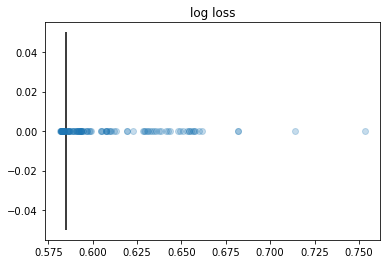

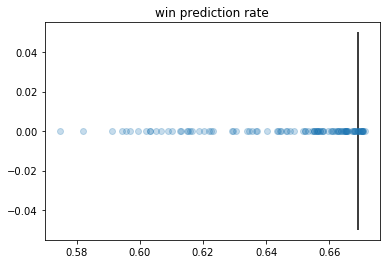

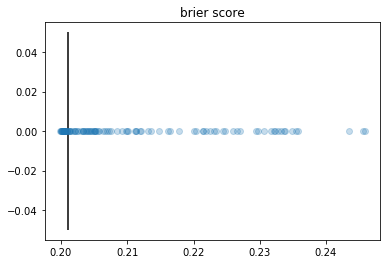

In [27]:
plt.plot(elos.param_data['ll'],np.zeros(100), 'o', alpha=0.25)
plt.vlines(0.585, -0.05,0.05)
plt.title('log loss')
plt.show()

plt.plot(elos.param_data['wp'],np.zeros(100), 'o', alpha=0.25)
plt.vlines(0.669, -0.05,0.05)
plt.title('win prediction rate')
plt.show()

plt.plot(elos.param_data['bs'],np.zeros(100),'o', alpha=0.25)
plt.vlines(0.201, -0.05,0.05)
plt.title('brier score')
plt.show()

**Most parameters drawn from this simple uniform distribution do pretty well.** The parameter population is the densest where the best costs are achieved. Recall that log-loss=0.585, win pred=0.669, brier score=0.201 were the costs achieved by the handpicked FiveThirtyEight parameters. The plots have vertical lines at these checkpoints.

# You bring your best fifty, I'll bring mine
How good are the best parameters from these randomly chosen ones? Let's pick the top 1% of parameters and see how they perform. I will pick the 50 best parameters (2010-2013) in each of the three categories from 5000 random ones with 1990-2013 data. This took a little while...

In [82]:
np.random.seed(5222020) # today's date!
elos = Elo_fam(1990,2013, 5000)
elos.update_all_ratings(2010)

Then we test them on 2014 data. For each category, to get a single probability, we took the 50 probabilities generated by the 50 models and averaged them. 

In [108]:
elos.sort_params(method = 'll')
bps_ll = np.array(elos.get_params_data().iloc[:50, :3])
elos.sort_params(method = 'wp')
bps_wp = np.array(elos.get_params_data().iloc[:50, :3])
elos.sort_params(method = 'bs')
bps_bs = np.array(elos.get_params_data().iloc[:50, :3])

elos = Elo_fam(1980, 2014, 5000)
a = elos.update_select_ratings(2014, bps_ll)
b = elos.update_select_ratings(2014, bps_wp)
c = elos.update_select_ratings(2014, bps_bs)

df = pd.DataFrame({'optimized_for': ['ll','wp','bs'], 
                   'll': [a[0],b[0],c[0]],
                   'wp': [a[1],b[1],c[1]],
                   'bs': [a[2],b[2],c[2]]})
print(df)

  optimized_for        ll        wp        bs
0            ll  0.583734  0.673573  0.200757
1            wp  0.586445  0.669837  0.201679
2            bs  0.584584  0.671875  0.201063


We see that the parameters which were obtained by optimizing for log-loss and Brier score were about equally effective at predicting 2014 matches, and the win-prediction-optimized parameters were less effective. But overall, all of these parameters are *not bad*. What do these parameters look like? Are they clustered anywhere? Are they all over the place? Recall the roles of the first, second, and third parameters, below denoted by $a,b,c$: $$k(n) = \frac{a}{(b+n)^c}.$$

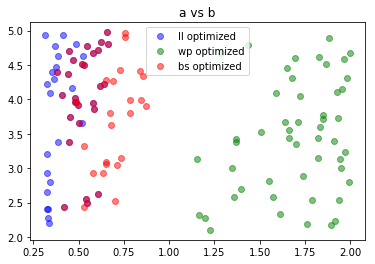

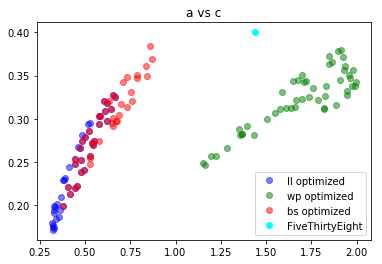

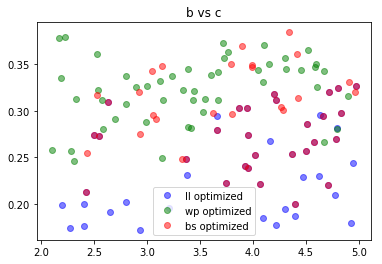

In [92]:
plt.plot(bps_ll[:,0], bps_ll[:,1], 'o', color = 'b', alpha=0.5, label = 'll optimized')
plt.plot(bps_wp[:,0], bps_wp[:,1], 'o', color = 'g', alpha=0.5, label = 'wp optimized')
plt.plot(bps_bs[:,0], bps_bs[:,1], 'o', color = 'r', alpha=0.5, label = 'bs optimized')
plt.legend()
plt.title('a vs b')
plt.show()

plt.plot(bps_ll[:,0], bps_ll[:,2], 'o', color = 'b', alpha=0.5, label = 'll optimized')
plt.plot(bps_wp[:,0], bps_wp[:,2], 'o', color = 'g', alpha=0.5, label = 'wp optimized')
plt.plot(bps_bs[:,0], bps_bs[:,2], 'o', color = 'r', alpha=0.5, label = 'bs optimized')
plt.plot(1.44, 0.40, 'o', color = 'cyan', label = 'FiveThirtyEight')
plt.legend()
plt.title('a vs c')
plt.show()

plt.plot(bps_ll[:,1], bps_ll[:,2], 'o', color = 'b', alpha=0.5, label = 'll optimized')
plt.plot(bps_wp[:,1], bps_wp[:,2], 'o', color = 'g', alpha=0.5, label = 'wp optimized')
plt.plot(bps_bs[:,1], bps_bs[:,2], 'o', color = 'r', alpha=0.5, label = 'bs optimized')
plt.legend()
plt.title('b vs c')
plt.show()

From these plots, we can see that basically b doesn't matter, and based on the type of error optimized for, the parameters cluster around different pairs of $(a,c)$ values. There is some overlap between the log-loss optimized parameters and the Brier-score optimized parameters, as evidenced by the purple points. 

The correlation in the second plot is due to the fact that, for a fixed $n,a,b,$ and $c$, the set of points $(x,y)$ satisfying $$\frac{x}{(b+n)^y} = \frac{a}{(b+n)^c}$$ is a log curve. 

In short, **there are a variety of parameter choices that can lead to effective predictions.** All of the parameters shown above achieve pretty good error rates. 

You may be wondering if maybe, two sets of parameters could be quite different as points in 3-d space but give rise to two very similar k-factor functions $k(n)$. This is true, as evidenced by the clustering around a log curve shown above. Our tentative conclusion is that parameters within a single group (that is, optimized for the same cost function) give rise to similar K-factor functions, but the three different groups (`ll`-optimized,`wp`-optimized,`bs`-optimized) give rise to quite different K-factor functions.

# The best K-factor functions

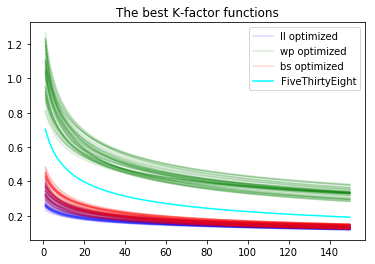

In [103]:
x = np.arange(1,150, 0.1)
def f(a,b,c,n):
    return (a/np.power(b+n, c))
plt.plot(x, f(*bps_ll[0],x), color='b', alpha=0.15, label='ll optimized')
for p in bps_ll[1:]:
    plt.plot(x, f(*p,x), color = 'b', alpha=0.15)
plt.plot(x, f(*bps_wp[0],x), color='g', alpha=0.15, label='wp optimized')
for p in bps_wp[1:]:
    plt.plot(x, f(*p,x), color = 'g', alpha=0.15)
plt.plot(x, f(*bps_bs[0],x), color='r', alpha=0.15, label='bs optimized')
for p in bps_bs[1:]:
    plt.plot(x, f(*p,x), color = 'r', alpha=0.15)
plt.plot(x, f(1.44, 5, 0.4, x), color = 'cyan', label='FiveThirtyEight')
plt.legend()
plt.title("The best K-factor functions")
plt.show()

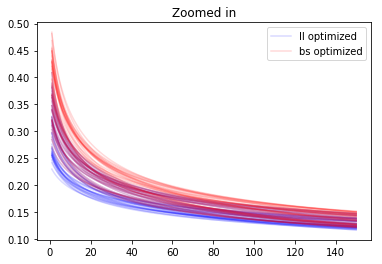

In [105]:
plt.plot(x, f(*bps_ll[0],x), color='b', alpha=0.15, label='ll optimized')
for p in bps_ll[1:]:
    plt.plot(x, f(*p,x), color = 'b', alpha=0.15)
plt.plot(x, f(*bps_bs[0],x), color='r', alpha=0.15, label='bs optimized')
for p in bps_bs[1:]:
    plt.plot(x, f(*p,x), color = 'r', alpha=0.15)
plt.legend()
plt.title('Zoomed in')
plt.show()

It seems clear that the differently colored K-factor functions behave quite differently, both near zero and at infinity.

# Testing on 2015-2019 data
The `ll`-optimized and `bs`-optimized parameters (trained on 1980-2013) performed a tiny better than the FiveThirtyEight model with respect to each of the three cost functions for 2014 data. What about for 2015-2019 data? We'll check it out here.

In [107]:
elos = Elo_fam(1980, 2019, 5000)
a = elos.update_select_ratings(2015, bps_ll)
b = elos.update_select_ratings(2015, bps_wp)
c = elos.update_select_ratings(2015, bps_bs)

elo_538 = Elo(1980,2019, param = [1.44, 5, 0.4])
ll, wp, bs = elo_538.update_ratings(2015)

df = pd.DataFrame({'optimized_for': ['ll','wp','bs','538'], 
                   'll': [a[0],b[0],c[0],ll],
                   'wp': [a[1],b[1],c[1],wp],
                   'bs': [a[2],b[2],c[2],bs]})
print(df)

  optimized_for        ll        wp        bs
0            ll  0.607112  0.658860  0.209942
1            wp  0.623405  0.657555  0.214121
2            bs  0.607411  0.658723  0.209912
3           538  0.611903  0.661607  0.210791


FiveThirtyEight takes the highest win prediction rate. On the other hand, the `ll`- and `bs`-optimized parameters achieve the best log-loss errors. Overall, aside from `wp`-optimized parameters, all of these models seem to give roughly equally effective predictions. (Mathematically, `wp` is not nice to work with because it is flat and discontinuous.)

# Preliminary conclusions
First, this analysis casts doubt on my initial feeling that there is one "true" K-factor function that we wish to approximate. It seems that many quite different K-factor functions can be used for prediction quite effectively and as near-optimally as you can get with this model.

Second, I believe that a random choice of parameters is a better one than a handpicked one, from an algorithmic point of view. It separates the parameters from most human fiddling (except the distributions that we pick from, which was pretty generic -- a uniform distribution on a large 3-d box). 

Third, the fact that many different K-factor functions work opens up a new frontier of prediction with Elo. Can we use, say, ten different Elo models at once to make a better prediction than any one of them can? Perhaps we can use a fast-updating Elo model in conjunction with a slow-updating Elo model to generate more effective predictions. We will explore these ideas and more in the next notebook.